In [16]:
## Getting the data
from influxdb import InfluxDBClient # install via " pip install influxdb "
import pandas as pd

client = InfluxDBClient (host='influxus.itu.dk', port =8086, username ='lsda',
password ='icanonlyread')
client.switch_database ('orkney')

def get_df(results):
    values = results.raw["series"][0]["values"]
    columns = results.raw["series"][0]["columns"]
    df = pd.DataFrame(values, columns=columns).set_index("time")
    df.index = pd.to_datetime(df.index ) # Convert to datetime - index
    return df

# Get the last 90 days of power generation data
generation = client.query (
    "SELECT * FROM Generation where time > now()-90d" # SELECT mean(Total) as Total FROM Generation where time > now()-90d group by time(3h)
    ) # Query written in InfluxQL

# Alternative query to align both datasets (group by time every 3 hours)
generation_1 = client.query (
    "SELECT sum(Total) as Total FROM Generation where time > now()-720d group by time(3h)" 
    )

# Get the last 90 days of weather forecasts with the shortest lead time
wind = client.query(
    "SELECT * FROM MetForecasts where time > now()-720d and time <= now() and Lead_hours = '1'"
    )# Query written in InfluxQL

# generator power every minute
gen_df = get_df(generation)
# generator power grouped by every 3 hours
gen_df_3h = get_df(generation_1)
# wind speed forecast every 3 hours
wind_df = get_df(wind)

In [17]:
# step 1: joining df

df = pd.concat([gen_df_3h, wind_df], axis=1) # one way of concatenating two datasets; 

# Round Speed and Total to two digits
df["Speed"] = df["Speed"].apply(lambda x: float("{:.2f}".format(x)))
df["Total"] = df["Total"].apply(lambda x: float("{:.2f}".format(x)))

# Fill total values
df["Total"].fillna(df["Total"].median(), inplace=True)

df

,Total,Direction,Lead_hours,Source_time,Speed
time,,,,,
2019-10-15 15:00:00+00:00,1924.68,NaN,NaN,NaN,NaN
2019-10-15 18:00:00+00:00,3438.00,E,1,1.571152e+09,8.05
2019-10-15 21:00:00+00:00,2688.65,E,1,1.571162e+09,8.05
2019-10-16 00:00:00+00:00,2113.69,ENE,1,1.571173e+09,8.05
2019-10-16 03:00:00+00:00,782.25,E,1,1.571184e+09,5.81
...,...,...,...,...,...
2021-10-04 03:00:00+00:00,4093.01,WSW,1,1.633306e+09,12.96
2021-10-04 06:00:00+00:00,2687.64,WSW,1,1.633316e+09,9.83
2021-10-04 09:00:00+00:00,2170.65,SW,1,1.633327e+09,9.83


In [18]:
# step 2: drop unnecessary cols
df.drop(["Lead_hours", "Source_time"], axis=1, inplace=True)

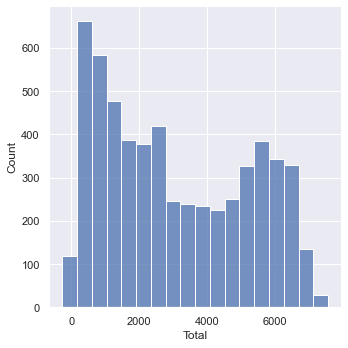

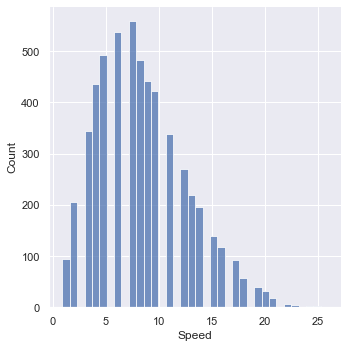

In [19]:
#exploring the data

# example visualize data results
import seaborn as sns
import matplotlib.pylab as plt
sns.set(color_codes=True)

# very useful
# sns.pairplot(df_prepared[["Speed", "Total"]])

# fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
# fig.suptitle('Distribution of data points: Total vs. Speed')

# Skewness of Total value
sns.displot(df,x=df["Total"])

# Skewness of Speed value
sns.displot(df, x=df["Speed"])


Unique speed values: 26


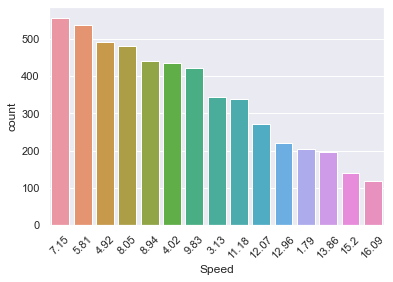

In [20]:

sns.countplot(x="Speed",data=df, order=df.Speed.value_counts().iloc[:15].index)

plt.xticks(rotation=45)

print("Unique speed values: " + str(df['Speed'].nunique()))


In [7]:
# Use preprocessing steps from SciKit for instance
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# for plotting
line = np.linspace(-1,1,100).reshape(-1,1)

num_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median', copy=False)),
    ('std_scaler', StandardScaler(copy=False)),
])

cat_pipe = Pipeline([
    ('one_hot', OneHotEncoder(sparse=False, handle_unknown='ignore')),
])

# two pipelines combined in the column transformer
full_transform = ColumnTransformer([
    ("num", num_pipe, ["Speed"]),
    ("cat", cat_pipe, ["Direction"]),
])


full_pipeline = Pipeline([
    ('trf', full_transform),
    ("poly", PolynomialFeatures(include_bias=False, degree=3)),
    ('linear', LinearRegression())
])


In [8]:
# now split data into training & test
X_train, X_test, y_train, y_test = train_test_split(df[["Speed","Direction"]], df[["Total"]], test_size=0.33, random_state=42, shuffle=False)

In [9]:
# Using the full pipeline

full_pipeline.fit(X_train, y_train)

full_pipeline.score(X_test, y_test)


0.719802323528584

In [10]:
from sklearn.metrics import mean_absolute_percentage_error
# make prediction and combine results
# make prediction based on test data
y_prediction = pd.DataFrame(full_pipeline.predict(X_test)) # poly regression
y_prediction.rename(columns={ y_prediction.columns[0]: "Prediction"}, inplace=True)

# align indexes
y_prediction.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# get x test data
# X_test_df = pd.DataFrame(X_test["Speed"])
# X_test_df.rename(columns={X_test_df.columns[0]: "Speed"}, inplace=True) 

df_prediction_combined = pd.concat([X_test["Speed"], y_prediction], axis=1)

# Check accuracy of prediction with explained variance (1.0 is best, lower the worse)
mean_absolute_percentage_error(y_test, full_pipeline.predict(X_test))

df_prediction_combined

,Speed,Prediction
0,9.83,3391.875
1,11.18,4861.250
2,8.05,2981.375
3,9.83,4138.500
4,5.81,2001.875
...,...,...
1897,12.96,5502.000
1898,9.83,3975.250
1899,9.83,3805.000
1900,8.05,3479.375


C:\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Prediction of linear regression with polynomial features')

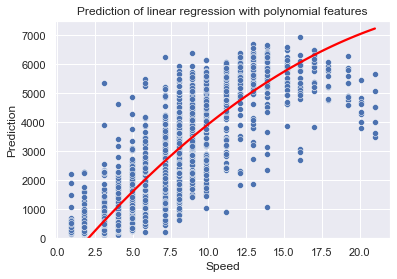

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.ylim(0, 7500)
# one scatterplot showing the test values
sns.scatterplot(X_test["Speed"], y_test["Total"])


# other plot showing the estimated values
sns.regplot(x="Speed", y="Prediction", data=df_prediction_combined,
           order=2, ci=None, scatter=False, scatter_kws={"s": 5}, color="red").set_title("Prediction of linear regression with polynomial features")



In [12]:
# knearest neighbor model
from sklearn.neighbors import KNeighborsRegressor

# kneighbor = KNeighborsRegressor(n_neighbors=10) #increased for better results

kn_pipeline = Pipeline([
    ('trf', full_transform),
    ("poly", PolynomialFeatures(include_bias=False, degree=3)),
    ('linear', KNeighborsRegressor(n_neighbors=10))
])

# Train the pipeline
poly_kn = kn_pipeline.fit(X_train, y_train)

# Test scores of pipeline
poly_kn.score(X_test, y_test)

# kneighbor.fit(X_, y_train)
# kneighbor.score(X_test_, y_test)


0.7035646207974421

In [13]:
# predict with kneighbor
y_predicted_kn = pd.DataFrame(poly_kn.predict(X_test))
y_predicted_kn.rename(columns={ y_predicted_kn.columns[0]: "Prediction"}, inplace=True)

df_prediction_combined_kn = pd.concat([X_test, y_predicted_kn], axis=1) #X_test_df from above

# final_mse = mean_squared_error(y_test, kn_pipeline.predict(X_test))

C:\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'K-nearest neighbor prediction with k=10')

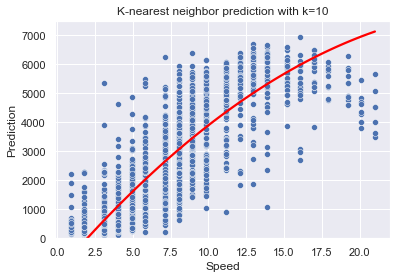

In [14]:
# one scatterplot showing the test values
sns.scatterplot(X_test["Speed"], y_test["Total"])
plt.ylim(0, 7500)

# other plot showing the estimated values
sns.regplot(x="Speed", y="Prediction", data=df_prediction_combined_kn,
           order=2, ci=None, scatter=False, scatter_kws={"s": 5}, color="red").set_title("K-nearest neighbor prediction with k=10")

In [15]:
# Evaluate with kfold cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from numpy import mean
from numpy import std

#prepare cross validation procedure
cv = KFold(n_splits=3, random_state=None)
# compare different regression models
scores_lin_reg = cross_val_score(full_pipeline, df[["Speed", "Direction"]], df["Total"], cv=cv)
scores_kneighbors = cross_val_score(kn_pipeline, df[["Speed", "Direction"]], df["Total"], cv=cv)

#report performance
print("Accuracy Linear Regression: %.3f (%.3f)" % (scores_lin_reg.mean(), scores_lin_reg.std()))
print("Accuracy K-nearest neighbors: %.3f (%.3f)" % (scores_kneighbors.mean(), scores_kneighbors.std()))


Accuracy Linear Regression: 0.703 (0.015)
Accuracy K-nearest neighbors: 0.693 (0.014)
